<a href="https://colab.research.google.com/github/Pauldeeny02/thesis-dhc-model/blob/main/actual_actual_Final_model_PD_DH_optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y glpk-utils
import os
import pyomo.environ as pyo
from pyomo.environ import *

# Create model
model = ConcreteModel()

# Define sets
technologies = ['air_source_hp', 'gas_boiler', 'industrial_hp', 'biomass_boiler','sofc', 'geothermal_hp', 'electric_boiler']
years = range(2025, 2051)  # From 2025 to 2050

# Define parameters
M = 10**9  # A sufficiently large constant (upper bound for x)
peak_heat_demand = 5.9458593  # MW
EFLH = 1800  # Effective Full Load Hours
r = 0.04  # Discount rate

# Energy Prices
average_gas_price = 66.10 # (eur/MWh)
average_electricity_price_business = 228.1 # (eur/MWh)
average_biomass_price = 55 # (eur/MWh)
average_biogas_price = 120 # (eur/MWh)

# Efficiencies
air_source_hp_efficiency = 3.60
geothermal_hp_efficiency = 1.60
industrial_hp_efficiency =  4.35# estimated value of every heat pump
biomass_boiler_efficiency = 1.00
sofc_heat_efficiency = 0.55
gas_boiler_efficiency = .90
electric_boiler_efficiency = 1

# Discount rate
discount_rate = 0.04

# Define year mapping (0 → 2025, 25 → 2050)
year_offset = 2025
years_to_check = range(2025, 2051)

# Dictionary of input data
data_dicts = {
    "nominal_investment": {
        ('air_source_hp', 0): 1.01, ('air_source_hp', 5): 0.91, ('air_source_hp', 15): 0.91, ('air_source_hp', 25): 0.91,
        ('gas_boiler', 0): 0.06, ('gas_boiler', 5): 0.05, ('gas_boiler', 25): 0.05,
        ('industrial_hp', 0): 1.32, ('industrial_hp', 5): 1.21, ('industrial_hp', 15): 1.21, ('industrial_hp', 25): 1.21,
        ('biomass_boiler', 0): 0.7337, ('biomass_boiler', 5): 0.7018, ('biomass_boiler', 25): 0.6274,
        ('sofc', 0): 2.13, ('sofc', 5): 2.13, ('sofc', 25): 0.85,
        ('geothermal_hp', 0): 1.31, ('geothermal_hp', 5): 1.27, ('geothermal_hp', 15): 1.22, ('geothermal_hp', 25): 1.19,
        ('electric_boiler', 0): .15, ('electric_boiler', 5): .15, ('electric_boiler', 15): .14, ('electric_boiler', 25): .14,
    },
    "variable_om": {
        ('air_source_hp', 0): 2.33, ('air_source_hp', 5): 2.67, ('air_source_hp', 15): 2.33, ('air_source_hp', 25): 2.84,
        ('gas_boiler', 0): 1.17, ('gas_boiler', 5): 1.06, ('gas_boiler', 25): 1.06,
        ('industrial_hp', 0): 2.86, ('industrial_hp', 5): 2.86, ('industrial_hp', 15): 3.39, ('industrial_hp', 25): 3.37,
        ('biomass_boiler', 0): 3.6474, ('biomass_boiler', 5): 3.6474, ('biomass_boiler', 25): 4.0195,
        ('sofc', 0): 0.00, ('sofc', 5): 0.00, ('sofc', 25): 0.00,
        ('geothermal_hp', 0): 2.24, ('geothermal_hp', 5): 2.28, ('geothermal_hp', 15): 2.26, ('geothermal_hp', 25): 2.24,
        ('electric_boiler', 0): .96, ('electric_boiler', 5): 1.06, ('electric_boiler', 15): 1.06, ('electric_boiler', 25): 1.06,
    },
    "fixed_om": {
        ('air_source_hp', 0): 2126.75, ('air_source_hp', 5): 2126.75, ('air_source_hp', 15): 2126.75, ('air_source_hp', 25): 2126.75,
        ('gas_boiler', 0): 2020.41, ('gas_boiler', 5): 2020.41, ('gas_boiler', 25): 1807.73,
        ('industrial_hp', 0): 2126.75, ('industrial_hp', 5): 2126.75, ('industrial_hp', 14): 2126.75, ('industrial_hp', 25): 2126.75,
        ('biomass_boiler', 0): 33496.24, ('biomass_boiler', 5): 33496.24, ('biomass_boiler', 25): 31475.83,
        ('sofc', 0): 106337.27, ('sofc', 5): 106337.27, ('sofc', 25): 42534.91,
        ('geothermal_hp', 0): 11484.43, ('geothermal_hp', 5): 11165.41, ('geothermal_hp', 15): 10740.06, ('geothermal_hp', 25): 10421.05,
        ('electric_boiler', 0): 1137.81, ('electric_boiler', 5): 1084.64, ('electric_boiler', 15): 1084.64, ('electric_boiler', 25): 978.3,
    }
}

# Function to map years and fill missing values
def process_data(data):
    mapped_data = {(tech, year + year_offset): value for (tech, year), value in data.items()}
    filled_data = {}

    for tech in {tech for tech, _ in mapped_data.keys()}:  # Unique technologies
        last_value = None
        for year in years_to_check:
            if (tech, year) in mapped_data:
                last_value = mapped_data[(tech, year)]  # Update last known value
            filled_data[(tech, year)] = last_value  # Assign last known value

    return filled_data

# Process all datasets
processed_data = {key: process_data(value) for key, value in data_dicts.items()}

# Decision Variables
model.x = Var(technologies, years, within=NonNegativeReals, bounds=(0, M))  # Continuous variable
model.y = Var(technologies, years, within=Binary)  # Binary variable
model.xy = Var(technologies, years, within=NonNegativeReals)  # Auxiliary variable for linearization
model.z = Var(technologies, years, within=NonNegativeReals)

# Constraints to linearize xy = x * y (Big-M Method)
def linearization_rule1(model, tech, t):
    return model.xy[tech, t] <= M * model.y[tech, t]  # Ensures xy is 0 if y is 0

def linearization_rule2(model, tech, t):
    return model.xy[tech, t] <= model.x[tech, t]  # Ensures xy is never greater than x

def linearization_rule4(model, tech, t):
    return model.xy[tech, t] >= 0  # Ensures xy is non-negative

# Add constraints to model
model.linearization1 = Constraint(technologies, years, rule=linearization_rule1)
model.linearization2 = Constraint(technologies, years, rule=linearization_rule2)
model.linearization4 = Constraint(technologies, years, rule=linearization_rule4)

# Heat Demand Constraint (Ensures demand is met)
def heat_demand_constraint(model, t):
    return sum(model.xy[tech, t] for tech in technologies) == peak_heat_demand

model.heat_demand = Constraint(years, rule=heat_demand_constraint)

# Define technology categories
renewable_techs = ['air_source_hp', 'biomass_boiler', 'geothermal_hp']
cogeneration_techs = ['sofc']
waste_heat_techs = ['industrial_hp']  # Add waste heat recovery sources if applicable
non_renewable_techs = ['gas_boiler', 'electric_boiler']

def renewable_constraint(model, t):
    if t >= 2025 and t < 2040:
        return sum(model.xy[tech, t] for tech in (renewable_techs+waste_heat_techs)) >= 0.5 * sum(model.xy[tech, t] for tech in technologies)
    elif t >= 2040 and t < 2050:
        return sum(model.xy[tech, t] for tech in (renewable_techs+waste_heat_techs)) >= 0.75 * sum(model.xy[tech, t] for tech in technologies)
    elif t >= 2050:
        return sum(model.xy[tech, t] for tech in (renewable_techs+waste_heat_techs)) == sum(model.xy[tech, t] for tech in technologies)

    else:
        return Constraint.Skip  # No renewable constraint before 2035

model.renewable_constraint = Constraint(years, rule=renewable_constraint)

model.z_constraint = ConstraintList()
for tech in technologies:
    for t in years:
        if t == 2025:
            model.z_constraint.add(model.z[tech, t] == model.x[tech, t])
        else:
            model.z_constraint.add(model.z[tech, t] == model.x[tech, t] - model.x[tech, t-1])

# Constraint: Limit industrial heat pump capacity to 1 MW
def industrial_hp_capacity_limit(model, t):
    return model.x['industrial_hp', t] <= 1

model.industrial_hp_capacity = Constraint(years, rule=industrial_hp_capacity_limit)

# Constraint: Limit industrial heat pump capacity to 1 MW
def biomass_boiler_capacity_limit(model, t):
    return model.x['biomass_boiler', t] <= 3

model.biomass_boiler_capacity = Constraint(years, rule=biomass_boiler_capacity_limit)

def electric_boiler_capacity_limit(model, t):
    return model.xy['electric_boiler', t] <= 2

model.electric_boiler_limit = Constraint(years, rule=electric_boiler_capacity_limit)

def total_cost_2(model):
    return sum((
        # Capital cost
        processed_data["nominal_investment"][(tech, t)] * model.z[tech, t] * 1e6 +

        # Fixed O&M cost
        processed_data["fixed_om"][(tech, t)] * model.xy[tech, t] +

        # Variable O&M cost (per MWh output)
        processed_data["variable_om"][(tech, t)] * model.xy[tech, t] * EFLH +

        # Fuel/Energy cost
        (
    # Gas boiler
    model.xy[tech, t] * EFLH / gas_boiler_efficiency * average_gas_price
    if tech == 'gas_boiler' else

    # Air source heat pump
    model.xy[tech, t] * EFLH / air_source_hp_efficiency * average_electricity_price_business
    if tech == 'air_source_hp' else

    # Industrial heat pump
    model.xy[tech, t] * EFLH / industrial_hp_efficiency * average_electricity_price_business
    if tech == 'industrial_hp' else

    # Geothermal heat pump
    model.xy[tech, t] * EFLH / geothermal_hp_efficiency * average_electricity_price_business
    if tech == 'geothermal_hp' else

    # Electric Boiler
    model.xy[tech, t] * EFLH / electric_boiler_efficiency * average_electricity_price_business
    if tech == 'electric_boiler' else

    # Biomass boiler
    model.xy[tech, t] * EFLH / biomass_boiler_efficiency * average_biomass_price
    if tech == 'biomass_boiler' else

    # SOFC (heat from biogas)
    model.xy[tech, t] * EFLH / sofc_heat_efficiency * average_biogas_price
    if tech == 'sofc' else 0
)

    ) * (1 / (1 + discount_rate)**(t - 2025))  # Discount factor
    for tech in technologies for t in years)

model.total_cost_2 = Objective(rule=total_cost_2, sense=minimize)

# **Solve Model**
solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
solver.solve(model, tee=True)
model.pprint()

# Get the base total cost (includes CAPEX + O&M + already discounted)
total_cost_value = pyo.value(model.total_cost_2)
print(f"Original total cost (including energy if modeled in objective): {total_cost_value:.2f} EUR")

# Calculate total discounted heat demand
heat_demand = sum(
    (pyo.value(model.xy[tech, t]) * EFLH) * (1 / (1.04 ** (t - 2025)))
    for tech in technologies for t in years
)
print(f"Total discounted heat demand: {heat_demand:.2f} MWh")

# Calculate Levelized Cost of Heat (EUR/MWh)
LCOH_i = total_cost_value / heat_demand
print(f"LCOH (including all costs): {LCOH_i:.2f} EUR/MWh")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
Suggested packages:
  libiodbc2-dev
The following NEW packages will be installed:
  glpk-utils libamd2 libcolamd2 libglpk40 libsuitesparseconfig5
0 upgraded, 5 newly installed, 0 to remove and 34 not upgraded.
Need to get 625 kB of archives.
After this operation, 2,158 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5.10.1+dfsg-4build1 [21.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libcolamd2 amd64 1:5.10.1+dfsg-4build1 [18.0 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libglpk40 amd64 5.0-1 [361 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 glpk-ut

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract values into a nested dictionary
capacity_data = {(tech, year): pyo.value(model.xy[tech, year]) for tech in technologies for year in years}

# Convert to DataFrame for easier plotting
df_capacity = pd.DataFrame(capacity_data.values(), index=pd.MultiIndex.from_tuples(capacity_data.keys(), names=["Technology", "Year"]), columns=["Capacity_MW"])

# Reshape the DataFrame
df_capacity = df_capacity.reset_index().pivot(index="Year", columns="Technology", values="Capacity_MW")


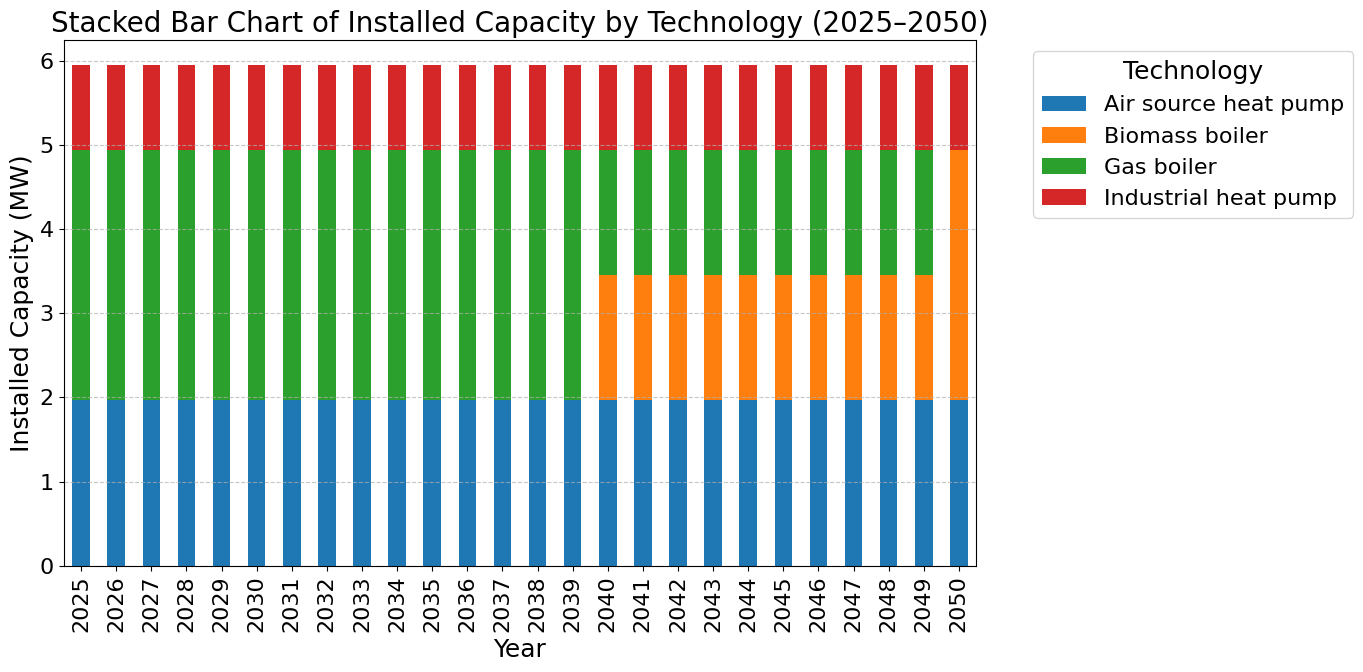

Technology  air_source_hp  biomass_boiler  gas_boiler  industrial_hp
Year                                                                
2025              1.97293        0.000000    2.972930            1.0
2026              1.97293        0.000000    2.972930            1.0
2027              1.97293        0.000000    2.972930            1.0
2028              1.97293        0.000000    2.972930            1.0
2029              1.97293        0.000000    2.972930            1.0
2030              1.97293        0.000000    2.972930            1.0
2031              1.97293        0.000000    2.972930            1.0
2032              1.97293        0.000000    2.972930            1.0
2033              1.97293        0.000000    2.972930            1.0
2034              1.97293        0.000000    2.972930            1.0
2035              1.97293        0.000000    2.972930            1.0
2036              1.97293        0.000000    2.972930            1.0
2037              1.97293        0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract results from model.xy
capacity_data = {(tech, year): pyo.value(model.xy[tech, year]) for tech in technologies for year in years}

# Create DataFrame
df_capacity = pd.DataFrame(
    capacity_data.values(),
    index=pd.MultiIndex.from_tuples(capacity_data.keys(), names=["Technology", "Year"]),
    columns=["Capacity_MW"]
)

# Pivot to get Technologies as columns and Years as index
df_plot = df_capacity.reset_index().pivot(index="Year", columns="Technology", values="Capacity_MW")

# Filter technologies that have non-zero values (i.e., appear on the plot)
used_techs = df_plot.columns[(df_plot != 0).any()]
df_plot = df_plot[used_techs]

legend_labels = {
    "gas_boiler": "Gas boiler",
    "electric_boiler": "Electric boiler",
    "air_source_hp": "Air source heat pump",
    "industrial_hp": "Industrial heat pump",
    "geothermal_hp": "Geothermal heat pump",
    "biomass_boiler": "Biomass boiler",
    "sofc": "SOFC"
}

# Update font sizes globally
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 18,
})

# Plot
ax = df_plot.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    title="Stacked Bar Chart of Installed Capacity by Technology (2025–2050)"
)

# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]  # Apply mapping
ax.legend(handles, new_labels, title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')

# Styling
plt.xlabel("Year")
plt.ylabel("Installed Capacity (MW)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(df_plot)


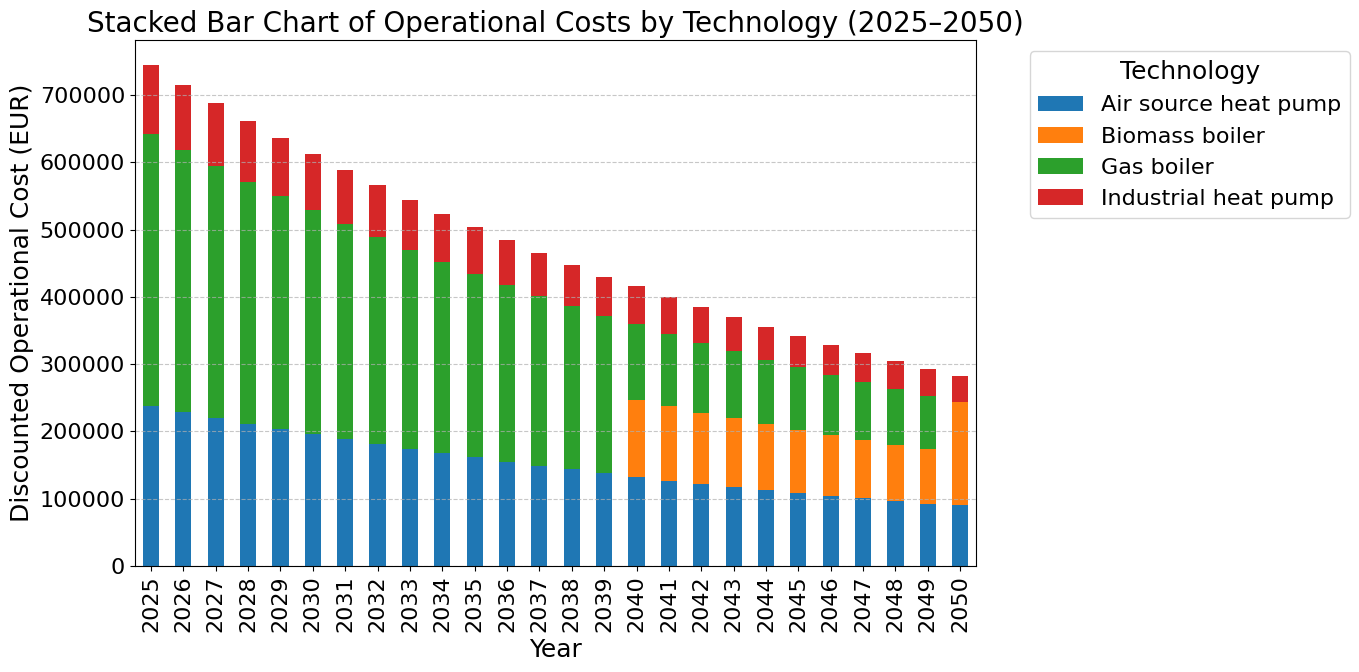

Technology  air_source_hp  biomass_boiler     gas_boiler  industrial_hp
Year                                                                   
2025        237483.021668        0.000000  405288.826367  101660.956897
2026        228349.059296        0.000000  389700.794584   97750.920093
2027        219566.403169        0.000000  374712.302484   93991.269320
2028        211121.541509        0.000000  360300.290850   90376.220500
2029        203001.482220        0.000000  346442.587356   86900.212019
2030        196186.154772        0.000000  332634.053228   83557.896172
2031        188640.533434        0.000000  319840.435796   80344.130935
2032        181385.128302        0.000000  307538.880573   77253.972053
2033        174408.777214        0.000000  295710.462089   74282.665435
2034        167700.747321        0.000000  284336.982778   71425.639842
2035        161250.718578        0.000000  273400.944979   68678.499848
2036        155048.767863        0.000000  262885.524018   66037

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define and process operational cost data
op_cost_data = {
    "Fixed O&M": {},
    "Variable O&M": {},
    "Fuel/Electricity": {}
}

for tech in technologies:
    for year in years:
        cap = pyo.value(model.xy[tech, year])
        discount_factor = 1 / ((1 + discount_rate) ** (year - 2025))

        fixed = processed_data["fixed_om"][(tech, year)] * cap * discount_factor
        variable = processed_data["variable_om"][(tech, year)] * cap * EFLH * discount_factor

        # Fuel or electricity cost depending on technology and efficiency
        if tech == 'gas_boiler':
            fuel_cost = cap * EFLH / gas_boiler_efficiency * average_gas_price
        elif tech == 'electric_boiler':
            fuel_cost = cap * EFLH / electric_boiler_efficiency * average_electricity_price_business
        elif tech == 'air_source_hp':
            fuel_cost = cap * EFLH / air_source_hp_efficiency * average_electricity_price_business
        elif tech == 'geothermal_hp':
            fuel_cost = cap * EFLH / geothermal_hp_efficiency * average_electricity_price_business
        elif tech == 'industrial_hp':
            fuel_cost = cap * EFLH / industrial_hp_efficiency * average_electricity_price_business
        elif tech == 'biomass_boiler':
            fuel_cost = cap * EFLH / biomass_boiler_efficiency * average_biomass_price
        elif tech == 'sofc':
            fuel_cost = cap * EFLH / sofc_heat_efficiency * average_biogas_price
        else:
            fuel_cost = 0

        fuel_cost *= discount_factor

        op_cost_data["Fixed O&M"][(tech, year)] = fixed
        op_cost_data["Variable O&M"][(tech, year)] = variable
        op_cost_data["Fuel/Electricity"][(tech, year)] = fuel_cost

# Build DataFrames
df_fixed = pd.DataFrame(op_cost_data["Fixed O&M"].values(),
    index=pd.MultiIndex.from_tuples(op_cost_data["Fixed O&M"].keys(), names=["Technology", "Year"]),
    columns=["Fixed O&M"])
df_variable = pd.DataFrame(op_cost_data["Variable O&M"].values(),
    index=pd.MultiIndex.from_tuples(op_cost_data["Variable O&M"].keys(), names=["Technology", "Year"]),
    columns=["Variable O&M"])
df_fuel = pd.DataFrame(op_cost_data["Fuel/Electricity"].values(),
    index=pd.MultiIndex.from_tuples(op_cost_data["Fuel/Electricity"].keys(), names=["Technology", "Year"]),
    columns=["Fuel/Electricity"])

# Merge and calculate total
df_operational = pd.concat([df_fixed, df_variable, df_fuel], axis=1).reset_index()
df_operational["Total"] = df_operational[["Fixed O&M", "Variable O&M", "Fuel/Electricity"]].sum(axis=1)

# Pivot to get total operational cost per tech per year
df_total_op = df_operational.pivot_table(index="Year", columns="Technology", values="Total", aggfunc="sum")

# Keep only used technologies
used_techs_op = df_total_op.columns[(df_total_op != 0).any()]
df_total_op = df_total_op[used_techs_op]

# Legend labels for plot
legend_labels = {
    "gas_boiler": "Gas boiler",
    "electric_boiler": "Electric boiler",
    "air_source_hp": "Air source heat pump",
    "industrial_hp": "Industrial heat pump",
    "geothermal_hp": "Geothermal heat pump",
    "biomass_boiler": "Biomass boiler",
    "sofc": "SOFC"
}

# Bigger fonts for plot
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 18,
})

# Plot
ax = df_total_op.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    title="Stacked Bar Chart of Operational Costs by Technology (2025–2050)"
)

# Apply formatted legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels.get(label, label) for label in labels]
ax.legend(handles, new_labels, title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')

# Axis labels and styling
plt.xlabel("Year")
plt.ylabel("Discounted Operational Cost (EUR)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(df_total_op)


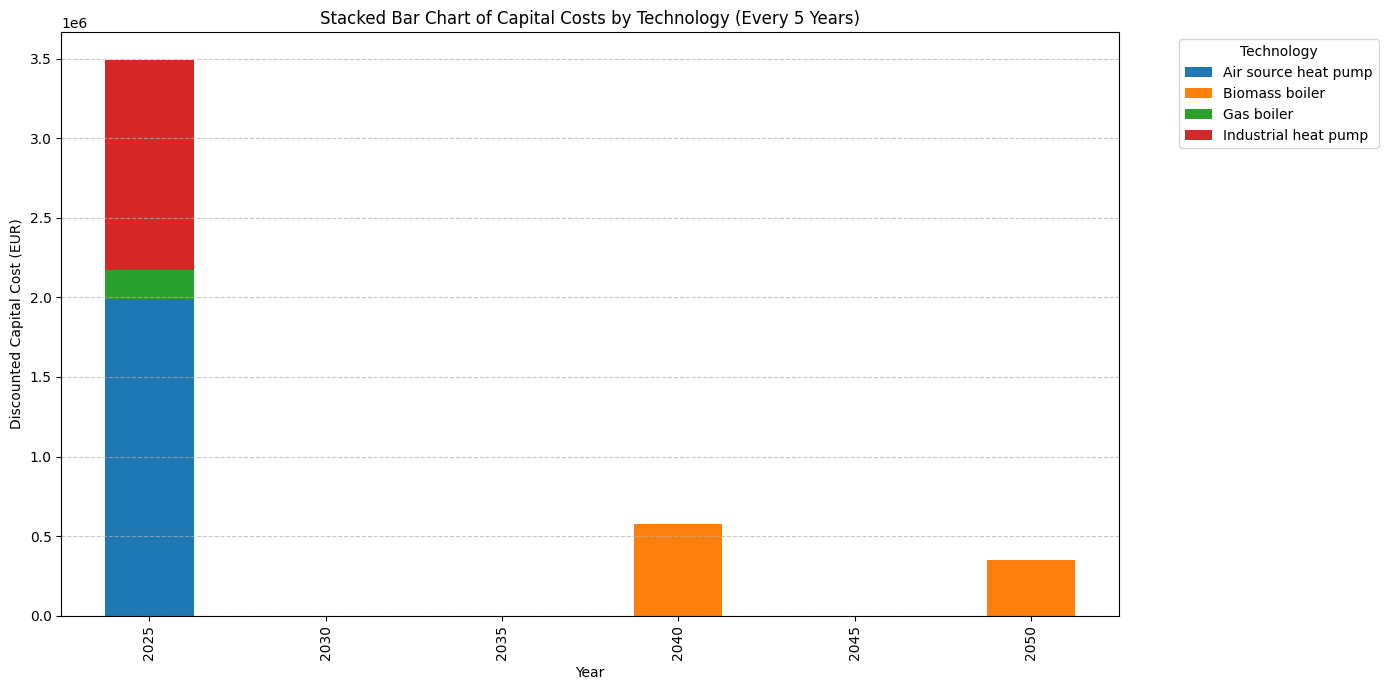

{('air_source_hp', 2025): 1992658.9465, ('air_source_hp', 2030): 0.0, ('air_source_hp', 2035): 0.0, ('air_source_hp', 2040): 0.0, ('air_source_hp', 2045): 0.0, ('air_source_hp', 2050): 0.0, ('gas_boiler', 2025): 178375.779, ('gas_boiler', 2030): 0.0, ('gas_boiler', 2035): 0.0, ('gas_boiler', 2040): 0.0, ('gas_boiler', 2045): 0.0, ('gas_boiler', 2050): 0.0, ('industrial_hp', 2025): 1320000.0, ('industrial_hp', 2030): 0.0, ('industrial_hp', 2035): 0.0, ('industrial_hp', 2040): 0.0, ('industrial_hp', 2045): 0.0, ('industrial_hp', 2050): 0.0, ('biomass_boiler', 2025): 0.0, ('biomass_boiler', 2030): 0.0, ('biomass_boiler', 2035): 0.0, ('biomass_boiler', 2040): 579252.492371418, ('biomass_boiler', 2045): 7.111919028003708e-11, ('biomass_boiler', 2050): 349836.9424219846, ('sofc', 2025): 0.0, ('sofc', 2030): 0.0, ('sofc', 2035): 0.0, ('sofc', 2040): 0.0, ('sofc', 2045): 0.0, ('sofc', 2050): 0.0, ('geothermal_hp', 2025): 0.0, ('geothermal_hp', 2030): 0.0, ('geothermal_hp', 2035): 0.0, ('geothe

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract capital cost data (z = new capacity installed)
capex_data = {}
for tech in technologies:
    for year in years:
        if year % 5 == 0:
            installed_capacity = pyo.value(model.z[tech, year])
            capex_per_mw = processed_data["nominal_investment"][(tech, year)] * 1e6  # EUR/MW to EUR
            discounted_capex = installed_capacity * capex_per_mw / ((1 + discount_rate) ** (year - 2025))
            capex_data[(tech, year)] = discounted_capex

# Create DataFrame
df_capex = pd.DataFrame(
    capex_data.values(),
    index=pd.MultiIndex.from_tuples(capex_data.keys(), names=["Technology", "Year"]),
    columns=["Capital Cost (EUR)"]
)

# Pivot to get Technologies as columns and Years as index
df_plot_capex = df_capex.reset_index().pivot(index="Year", columns="Technology", values="Capital Cost (EUR)")

# Filter out technologies that have zero capital investment
used_techs_capex = df_plot_capex.columns[(df_plot_capex != 0).any()]
df_plot_capex = df_plot_capex[used_techs_capex]

# Legend labels (same mapping for consistency)
legend_labels = {
    "gas_boiler": "Gas boiler",
    "electric_boiler": "Electric boiler",
    "air_source_hp": "Air source heat pump",
    "industrial_hp": "Industrial heat pump",
    "geothermal_hp": "Geothermal heat pump",
    "biomass_boiler": "Biomass boiler",
    "sofc": "SOFC"
}

# Plot
ax = df_plot_capex.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    title="Stacked Bar Chart of Capital Costs by Technology (Every 5 Years)"
)

# Apply legend formatting
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels.get(label, label) for label in labels]
ax.legend(handles, new_labels, title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')

# Axis labels and styling
plt.xlabel("Year")
plt.ylabel("Discounted Capital Cost (EUR)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(capex_data)

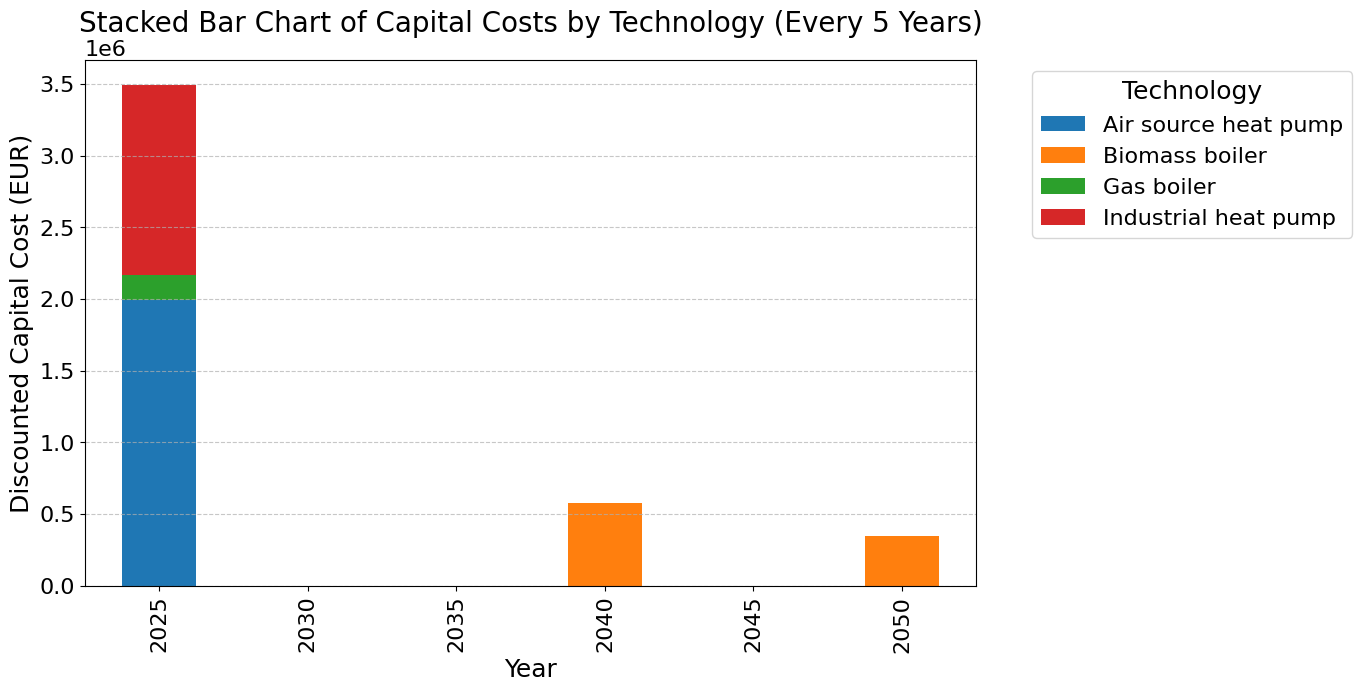

{('air_source_hp', 2025): 1992658.9465, ('air_source_hp', 2030): 0.0, ('air_source_hp', 2035): 0.0, ('air_source_hp', 2040): 0.0, ('air_source_hp', 2045): 0.0, ('air_source_hp', 2050): 0.0, ('gas_boiler', 2025): 178375.779, ('gas_boiler', 2030): 0.0, ('gas_boiler', 2035): 0.0, ('gas_boiler', 2040): 0.0, ('gas_boiler', 2045): 0.0, ('gas_boiler', 2050): 0.0, ('industrial_hp', 2025): 1320000.0, ('industrial_hp', 2030): 0.0, ('industrial_hp', 2035): 0.0, ('industrial_hp', 2040): 0.0, ('industrial_hp', 2045): 0.0, ('industrial_hp', 2050): 0.0, ('biomass_boiler', 2025): 0.0, ('biomass_boiler', 2030): 0.0, ('biomass_boiler', 2035): 0.0, ('biomass_boiler', 2040): 579252.492371418, ('biomass_boiler', 2045): 7.111919028003708e-11, ('biomass_boiler', 2050): 349836.9424219846, ('sofc', 2025): 0.0, ('sofc', 2030): 0.0, ('sofc', 2035): 0.0, ('sofc', 2040): 0.0, ('sofc', 2045): 0.0, ('sofc', 2050): 0.0, ('geothermal_hp', 2025): 0.0, ('geothermal_hp', 2030): 0.0, ('geothermal_hp', 2035): 0.0, ('geothe

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract capital cost data (z = new capacity installed)
capex_data = {}
for tech in technologies:
    for year in years:
        if year % 5 == 0:
            installed_capacity = pyo.value(model.z[tech, year])
            capex_per_mw = processed_data["nominal_investment"][(tech, year)] * 1e6  # EUR/MW to EUR
            discounted_capex = installed_capacity * capex_per_mw / ((1 + discount_rate) ** (year - 2025))
            capex_data[(tech, year)] = discounted_capex

# Create DataFrame
df_capex = pd.DataFrame(
    capex_data.values(),
    index=pd.MultiIndex.from_tuples(capex_data.keys(), names=["Technology", "Year"]),
    columns=["Capital Cost (EUR)"]
)

# Pivot to get Technologies as columns and Years as index
df_plot_capex = df_capex.reset_index().pivot(index="Year", columns="Technology", values="Capital Cost (EUR)")

# Filter out technologies that have zero capital investment
used_techs_capex = df_plot_capex.columns[(df_plot_capex != 0).any()]
df_plot_capex = df_plot_capex[used_techs_capex]

# Legend labels (consistent with other plots)
legend_labels = {
    "gas_boiler": "Gas boiler",
    "electric_boiler": "Electric boiler",
    "air_source_hp": "Air source heat pump",
    "industrial_hp": "Industrial heat pump",
    "geothermal_hp": "Geothermal heat pump",
    "biomass_boiler": "Biomass boiler",
    "sofc": "SOFC"
}

# Update font sizes globally
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 18,
})

# Plot
ax = df_plot_capex.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 7),
    title="Stacked Bar Chart of Capital Costs by Technology (Every 5 Years)"
)

# Apply formatted legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels.get(label, label) for label in labels]
ax.legend(handles, new_labels, title="Technology", bbox_to_anchor=(1.05, 1), loc='upper left')

# Axis labels and styling
plt.xlabel("Year")
plt.ylabel("Discounted Capital Cost (EUR)")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(capex_data)


In [ ]:

emission_factors = {
    'gas_boiler': .204,           # kg CO₂/MWh
    'electric_boiler': .2292,      # average grid emissions (could be dynamic)
    'biomass_boiler': 0,        # low but not zero (some emissions from supply chain)
    'sofc': 0,                   # assuming biogas is carbon neutral
    'air_source_hp': .2292,         # based on average grid intensity
    'industrial_hp': .2292,        # based on average grid intensity
    'geothermal_hp': .2292,
}

# Efficiencies
air_source_hp_efficiency = 3.60
geothermal_hp_efficiency = 1.60
industrial_hp_efficiency =  4.35# estimated value of every heat pump
biomass_boiler_efficiency = 1.00
sofc_heat_efficiency = 0.55
gas_boiler_efficiency = .90
electric_boiler_efficiency = 1

shadow_price_carbon = {
    2025: 335,
    2026: 349,
    2027: 363,
    2028: 377,
    2029: 392,
    2030: 408,
    2031: 424,
    2032: 441,
    2033: 459,
    2034: 477,
    2035: 496,
    2036: 516,
    2037: 537,
    2038: 558,
    2039: 580,
    2040: 604,
    2041: 628,
    2042: 653,
    2043: 679,
    2044: 706,
    2045: 735,
    2046: 764,
    2047: 794,
    2048: 826,
    2049: 859,
    2050: 890
}

In [ ]:
print(emissions_by_tech)

{'gas_boiler': 21833.195349599995, 'electric_boiler': 0.0, 'biomass_boiler': 0.0, 'sofc': 0.0, 'air_source_hp': 21162.74826650401, 'industrial_hp': 10726.560000000001, 'geothermal_hp': 0.0}


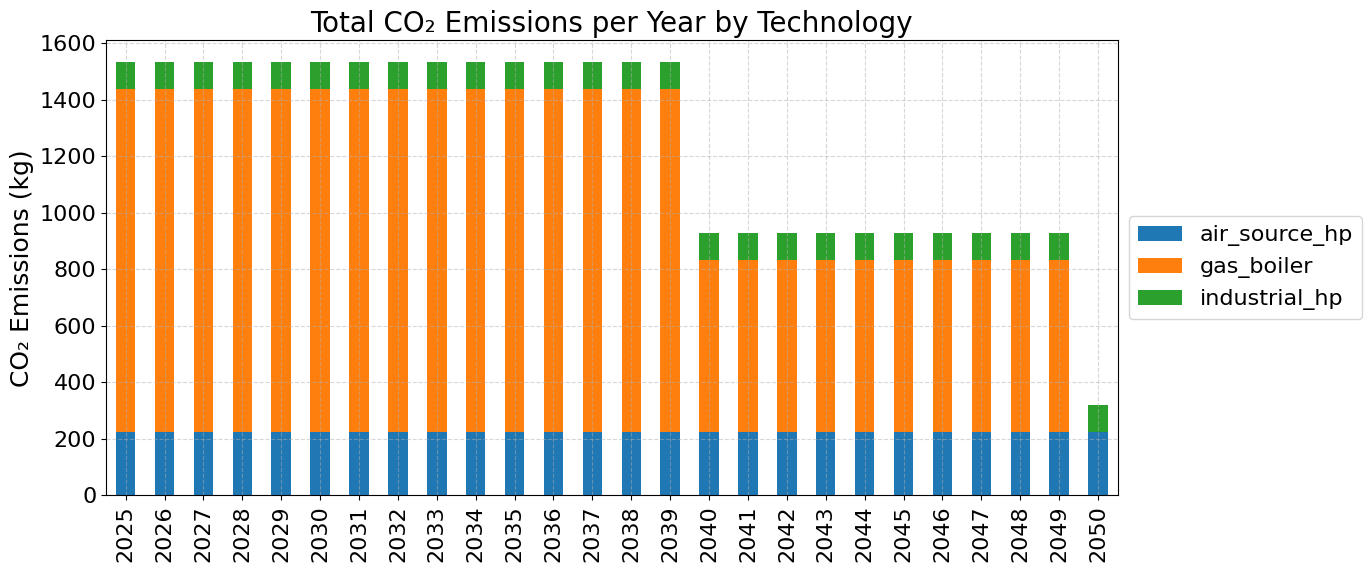

      air_source_hp   gas_boiler  industrial_hp
2025     226.097738  1212.955297      94.841379
2026     226.097738  1212.955297      94.841379
2027     226.097738  1212.955297      94.841379
2028     226.097738  1212.955297      94.841379
2029     226.097738  1212.955297      94.841379
2030     226.097738  1212.955297      94.841379
2031     226.097738  1212.955297      94.841379
2032     226.097738  1212.955297      94.841379
2033     226.097738  1212.955297      94.841379
2034     226.097738  1212.955297      94.841379
2035     226.097738  1212.955297      94.841379
2036     226.097738  1212.955297      94.841379
2037     226.097738  1212.955297      94.841379
2038     226.097738  1212.955297      94.841379
2039     226.097738  1212.955297      94.841379
2040     226.097738   606.477649      94.841379
2041     226.097738   606.477649      94.841379
2042     226.097738   606.477649      94.841379
2043     226.097738   606.477649      94.841379
2044     226.097738   606.477649      94

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo

EFLH = 1800

# Emission factors in kg CO₂ per MWh of energy input
emission_factors = {
    'gas_boiler': 0.204,
    'electric_boiler': 0.2292,
    'biomass_boiler': 0.0,
    'sofc': 0.0,
    'air_source_hp': 0.2292,
    'industrial_hp': 0.2292,
    'geothermal_hp': 0.2292,
}

# Efficiencies
efficiencies = {
    'air_source_hp': 3.60,
    'geothermal_hp': 1.60,
    'industrial_hp': 4.35,
    'biomass_boiler': 1.00,
    'sofc': 0.55,
    'gas_boiler': 0.90,
    'electric_boiler': 1.00
}

shadow_price_carbon = {
    2025: 335,
    2026: 349,
    2027: 363,
    2028: 377,
    2029: 392,
    2030: 408,
    2031: 424,
    2032: 441,
    2033: 459,
    2034: 477,
    2035: 496,
    2036: 516,
    2037: 537,
    2038: 558,
    2039: 580,
    2040: 604,
    2041: 628,
    2042: 653,
    2043: 679,
    2044: 706,
    2045: 735,
    2046: 764,
    2047: 794,
    2048: 826,
    2049: 859,
    2050: 890
}
# Store emissions and carbon cost by year and technology
emissions_per_year_tech = {year: {tech: 0 for tech in technologies} for year in years}
carbon_cost_per_year_tech = {year: {tech: 0 for tech in technologies} for year in years}

# Calculate real values from model
for tech in technologies:
    for year in years:
        heat_output = pyo.value(model.xy[tech, year]) * EFLH
        emission_factor = emission_factors[tech]
        efficiency = efficiencies[tech]
        emissions_kg = heat_output * (emission_factor / efficiency) if efficiency > 0 else 0
        emissions_per_year_tech[year][tech] = emissions_kg
        carbon_cost_per_year_tech[year][tech] = (emissions_kg / 1000) * shadow_price_carbon[year]

# Convert to DataFrames
df_emissions = pd.DataFrame(emissions_per_year_tech).T
df_carbon_cost = pd.DataFrame(carbon_cost_per_year_tech).T

# Drop technologies not used (columns with all zeros)
df_emissions = df_emissions.loc[:, (df_emissions != 0).any(axis=0)]
df_carbon_cost = df_carbon_cost.loc[:, (df_carbon_cost != 0).any(axis=0)]

# Plot total CO₂ emissions per year by tech
ax1 = df_emissions.plot(kind='bar', stacked=True, figsize=(14, 6), title="Total CO₂ Emissions per Year by Technology")
ax1.set_ylabel("CO₂ Emissions (kg)")
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Optional: print data for verification
print(df_emissions)


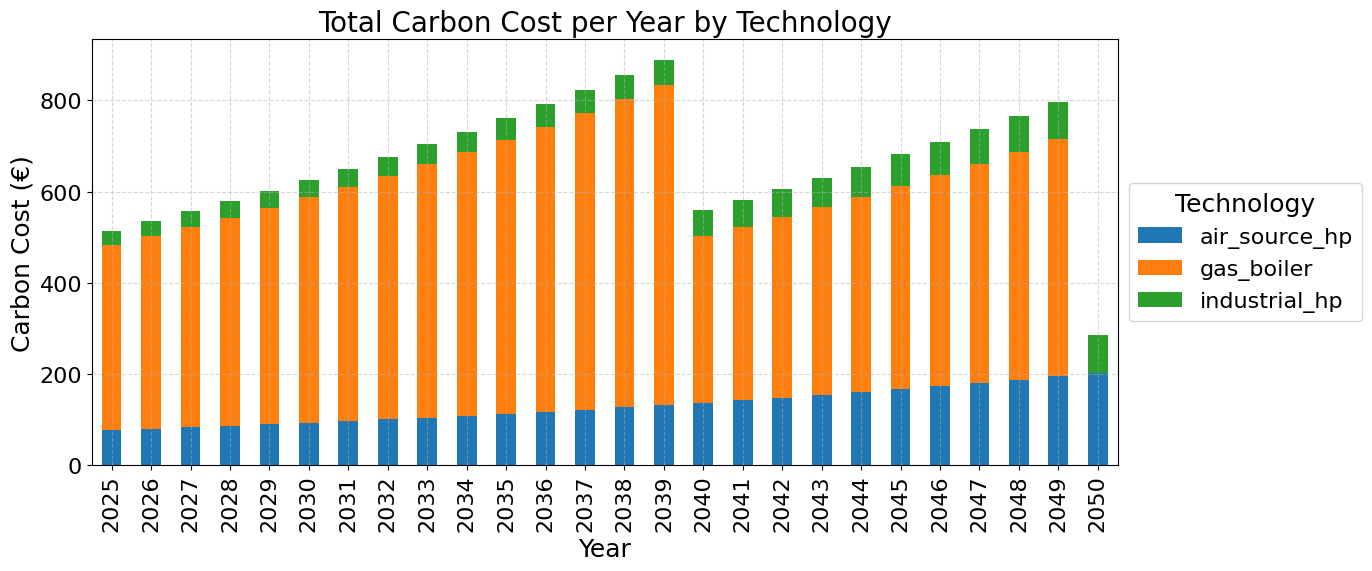

      air_source_hp  gas_boiler  industrial_hp
2025      75.742742  406.340025      31.771862
2026      78.908111  423.321399      33.099641
2027      82.073479  440.302773      34.427421
2028      85.238847  457.284147      35.755200
2029      88.630313  475.478477      37.177821
2030      92.247877  494.885761      38.695283
2031      95.865441  514.293046      40.212745
2032      99.709102  534.913286      41.825048
2033     103.778862  556.746481      43.532193
2034     107.848621  578.579677      45.239338
2035     112.144478  601.625827      47.041324
2036     116.666433  625.884933      48.938152
2037     121.414485  651.356995      50.929821
2038     126.162538  676.829056      52.921490
2039     131.136688  703.514072      55.008000
2040     136.563034  366.312500      57.284193
2041     141.989379  380.867963      59.560386
2042     147.641823  396.029905      61.931421
2043     153.520364  411.798323      64.397297
2044     159.625003  428.173220      66.958014
2045     166.

In [ ]:
# Update global font sizes for consistency
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "legend.title_fontsize": 18,
})

# Plot carbon cost per year by technology
ax2 = df_carbon_cost.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 6),
    title="Total Carbon Cost per Year by Technology"
)

ax2.set_ylabel("Carbon Cost (€)")
ax2.set_xlabel("Year")
ax2.legend(title="Technology", loc='center left', bbox_to_anchor=(1, 0.5))
ax2.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(df_carbon_cost)
